In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("/Users/Sung/Downloads/airpro.csv", encoding="utf-8")

In [2]:
data = data.fillna(method="ffill")

In [3]:
data.tail(10)

,Unnamed: 0,word,rule_label,IOB,sentence,enter,review,pos
7061,7061,소음,NC,I,503,371,11,Noun
7062,7062,확실하다,O,I,503,371,11,Adjective
7063,7063,차단,NC,B,503,371,11,Noun
7064,7064,되어다,O,B,503,371,11,Verb
7065,7065,강의,O,B,503,371,11,Noun
7066,7066,들다,O,B,503,371,11,Verb
7067,7067,때,O,B,503,371,11,Noun
7068,7068,나,O,B,503,371,11,Josa
7069,7069,명상,O,B,503,371,11,Noun
7070,7070,어플,O,B,503,371,11,Noun


In [4]:
words = list(set(data["word"].values))
n_words = len(words); n_words

1819

In [5]:
tags = list(set(data["rule_label"].values))
n_tags = len(tags); n_tags

16

In [6]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["word"].values.tolist(),
                                                           s["pos"].values.tolist(),
                                                           s["rule_label"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
getter = SentenceGetter(data)

In [8]:
sent = getter.get_next()

In [9]:
print(sent)

None


In [10]:
sentences = getter.sentences

In [11]:
max_len = 75
max_len_char = 10

In [12]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [13]:
print(word2idx["소리"])
print(tag2idx["SQ"])

411
10


In [14]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in sentences]

In [15]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

In [16]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)


741


In [17]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0


In [18]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [19]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [20]:
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

Split

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

In [24]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

In [25]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

model = Model([word_in, char_in], out)

In [26]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [27]:
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 10)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 75, 10, 10)   7430        input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 75, 20)       36420       input_1[0][0]                    
_______________________________________________________________________________________

In [28]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.1, verbose=1)

Epoch 1/10
13/13 [==============================] - 3s 258ms/step - loss: 0.5035 - acc: 0.8158 - val_loss: 0.4764 - val_acc: 0.9493
Epoch 2/10
13/13 [==============================] - 2s 145ms/step - loss: 0.4464 - acc: 0.9109 - val_loss: 0.3712 - val_acc: 0.9493
Epoch 3/10
13/13 [==============================] - 3s 194ms/step - loss: 0.3259 - acc: 0.9109 - val_loss: 0.2223 - val_acc: 0.9493
Epoch 4/10
13/13 [==============================] - 2s 184ms/step - loss: 0.1945 - acc: 0.9109 - val_loss: 0.1108 - val_acc: 0.9493
Epoch 5/10
13/13 [==============================] - 2s 163ms/step - loss: 0.1281 - acc: 0.9109 - val_loss: 0.0793 - val_acc: 0.9493
Epoch 6/10
13/13 [==============================] - 2s 156ms/step - loss: 0.1124 - acc: 0.9109 - val_loss: 0.0723 - val_acc: 0.9493
Epoch 7/10
13/13 [==============================] - 2s 131ms/step - loss: 0.1072 - acc: 0.9109 - val_loss: 0.0708 - val_acc: 0.9493
Epoch 8/10
13/13 [==============================] - 2s 131ms/step - loss: 0.

In [29]:
hist = pd.DataFrame(history.history)

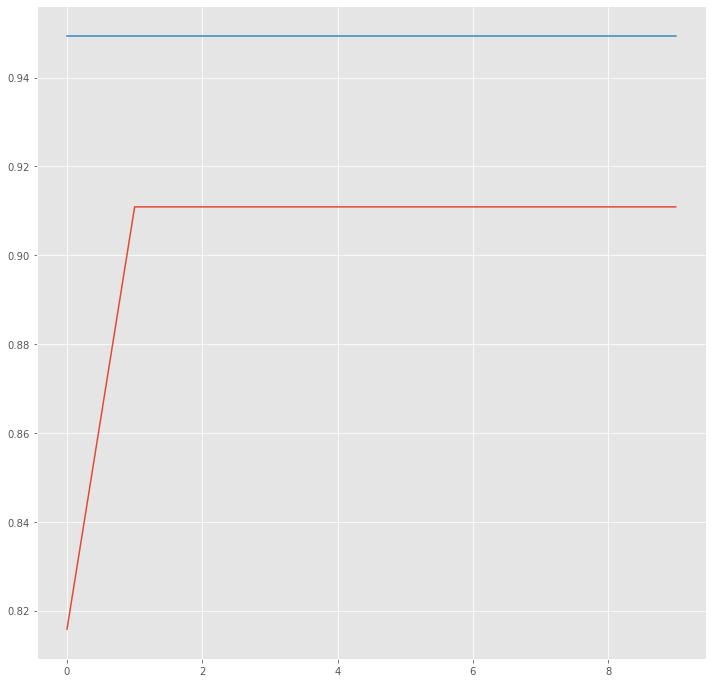

In [30]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [31]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])

In [48]:
i = 16
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word           ||True ||Pred
생각             : O     O
이              : O     O
드              : O     O
나              : O     O
어디             : O     O
까지나            : O     O
이어폰            : O     O
이라는            : O     O
카테고리           : O     O
안              : O     O
에서             : O     O
상위             : O     O
성능             : O     O
일              : O     O
뿐              : O     O
.              : O     O
논              : O     O
외로             : O     O
노캔             : NC    O
을              : O     O
가지다            : O     O
이어폰            : O     O
,              : O     O
헤드폰            : O     O
들              : O     O
특성             : O     O
상              : O     O
매우             : O     O
조용하다           : NC    O
곳              : O     O
에서             : O     O
노캔             : NC    O
을              : O     O
켜다             : O     O
경우             : O     O
들리다            : O     O
'              : O     O
쉬              : O     O
~              : O   